# 1. Getting Used to Handling Language Data

In [177]:
from datasets import load_dataset
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

dataset = load_dataset("ag_news")

2023-01-25 21:57:56 WARNING  Found cached dataset ag_news (/Users/johnnybui/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 50.70it/s]


In [45]:
dataset['train']['text'][0:10]

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.',
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.',
 'Oil prices soar to all-time record, posing new menace to US economy (A

In [185]:
from collections import Counter 
from re import sub, compile
import matplotlib.pyplot as plt
import numpy as np

class UnimplementedFunctionError(Exception):
    pass

class Vocabulary:

    def __init__(self, corpus):

        self.word2idx, self.idx2word, self.freq = self.build_vocab(corpus)
        self.size = len(self.word2idx)

    def __len__(self):
        return len(self.word2idx.keys())
    
    def most_common(self, k):
        freq = sorted(self.freq.items(), key=lambda x: x[1], reverse=True)
        return [t for t,f in freq[:k]]


    def text2idx(self, text):
        tokens = self.tokenize(text)
        return [self.word2idx[t] if t in self.word2idx.keys() else self.word2idx['UNK'] for t in tokens]

    def idx2text(self, idxs):
        return [self.idx2word[i] if i in self.idx2word.keys() else 'UNK' for i in idxs]


    ###########################
    ## TASK 1.1                ##
    ###########################
    def tokenize(self, text):
        """
        
        tokenize takes in a string of text, remove punctuations and returns an 
        array of strings splitting the text into discrete tokens.

        :params: 
        - text: a string, e.g. "The blue dog jumped, but not high."

        :returns:
        - tokens: a list of strings derived from the text, e.g. ["the", "blue", 
        "dog", "jumped", "but", "not", "high"] for word-level tokenization
        
        """ 
        text = sub(r'[^\w\s]', '', text)
        return text.split()



    ###########################
    ## TASK 1.2                 ##
    ###########################
    def build_vocab(self,corpus):
        """
        
        build_vocab takes in list of strings corresponding to a text corpus, tokenizes the strings, and builds a finite vocabulary

        :params:
        - corpus: a list string to build a vocabulary over

        :returns: 
        - word2idx: a dictionary mapping token strings to their numerical index in the dictionary e.g. { "dog": 0, "but":1, ..., "UNK":129}
        - idx2word: the inverse of word2idx mapping an index in the vocabulary to its word e.g. {0: "dog", 1:"but", ..., 129:"UNK"}
        - freq: a dictionary of words and frequency counts over the corpus (including words not in the dictionary), e.g. {"dog":102, "the": 18023, ...}

        """ 
        word2idx = {}
        idx2word = {}
        freq = {}
        
        # Count tokens
        for s in corpus:
            for token in self.tokenize(s):
                if token not in freq.keys():
                    freq[token] = 1
                else:
                    freq[token] += 1
                    
        # Cutoff the tail
        cutoff = 50
        sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        
        word2idx["UNK"] = 0
        idx2word[0] = "UNK"
        id = 1   # Preserve 0 for UNK
        for (token,cnt) in sorted_freq:
            if cnt > 50:
                word2idx[token] = id
                idx2word[id] = token
                id += 1
            else:
                break
            
        
        return word2idx, idx2word, freq
    
    ###########################
    ## TASK 1.3              ##
    ###########################
    def make_vocab_charts(self):
        """
        
        make_vocab_charts plots word frequency and cumulative coverage charts 
        for this vocabulary. See handout for more details

        
        """ 
        cutoff = 50
        
        ax1 = plt.figure(figsize=(16,6))
        ax1 = plt.subplot(1,2,1)
        
        sorted_freq = self.most_common(len(self.freq))
        most_freq = [self.freq[k] for k in sorted_freq]
        
        cutoff_idx = -1
        occ_sum = sum(most_freq)
        cfc = [0]
        for i in range(len(most_freq)):
            if cutoff_idx == -1 and most_freq[i] < cutoff:
                cutoff_idx = i - 1
                
            cfc.append((cfc[-1] + most_freq[i] / occ_sum))
        
        ax1.plot(list(range(len(most_freq))), most_freq, color='b')
        ax1.axhline(y=cutoff, color='r')
        ax1.text(0.8*len(most_freq), cutoff * 1.2,"freq = %d" % cutoff)
        ax1.set_yscale("log")
        ax1.set_xlabel("Token ID (sorted by frequency)")
        ax1.set_ylabel("Frequency")
        ax1.set_title("Token Frequency Distribution")

        ax2 = plt.subplot(1,2,2)
        ax2.plot(list(range(len(cfc[1:]))), cfc[1:], color='b')
        ax2.axvline(x=cutoff_idx, color='r', label=str(most_freq[cutoff_idx]))
        ax2.text(1.2*cutoff_idx, 0.95*cfc[cutoff_idx], "%.02f" % cfc[cutoff_idx])
        plt.title("Cumulative Fraction Covered")
        plt.xlabel("Token ID (sorted by frequency)")
        plt.ylabel("Fraction of Token Occurences Covered")
        
        plt.savefig("Vocabulary.jpg")


In [186]:
vocab = Vocabulary(dataset['train']['text'])
vocab.text2idx("Bears are hug sdfsf e~~~~!!!")

[1959, 36, 0, 0, 0]

In [175]:
vocab.tokenize("Bears are huge sdfsf ~~~~!!!")

['Bears', 'are', 'huge', 'sdfsf']

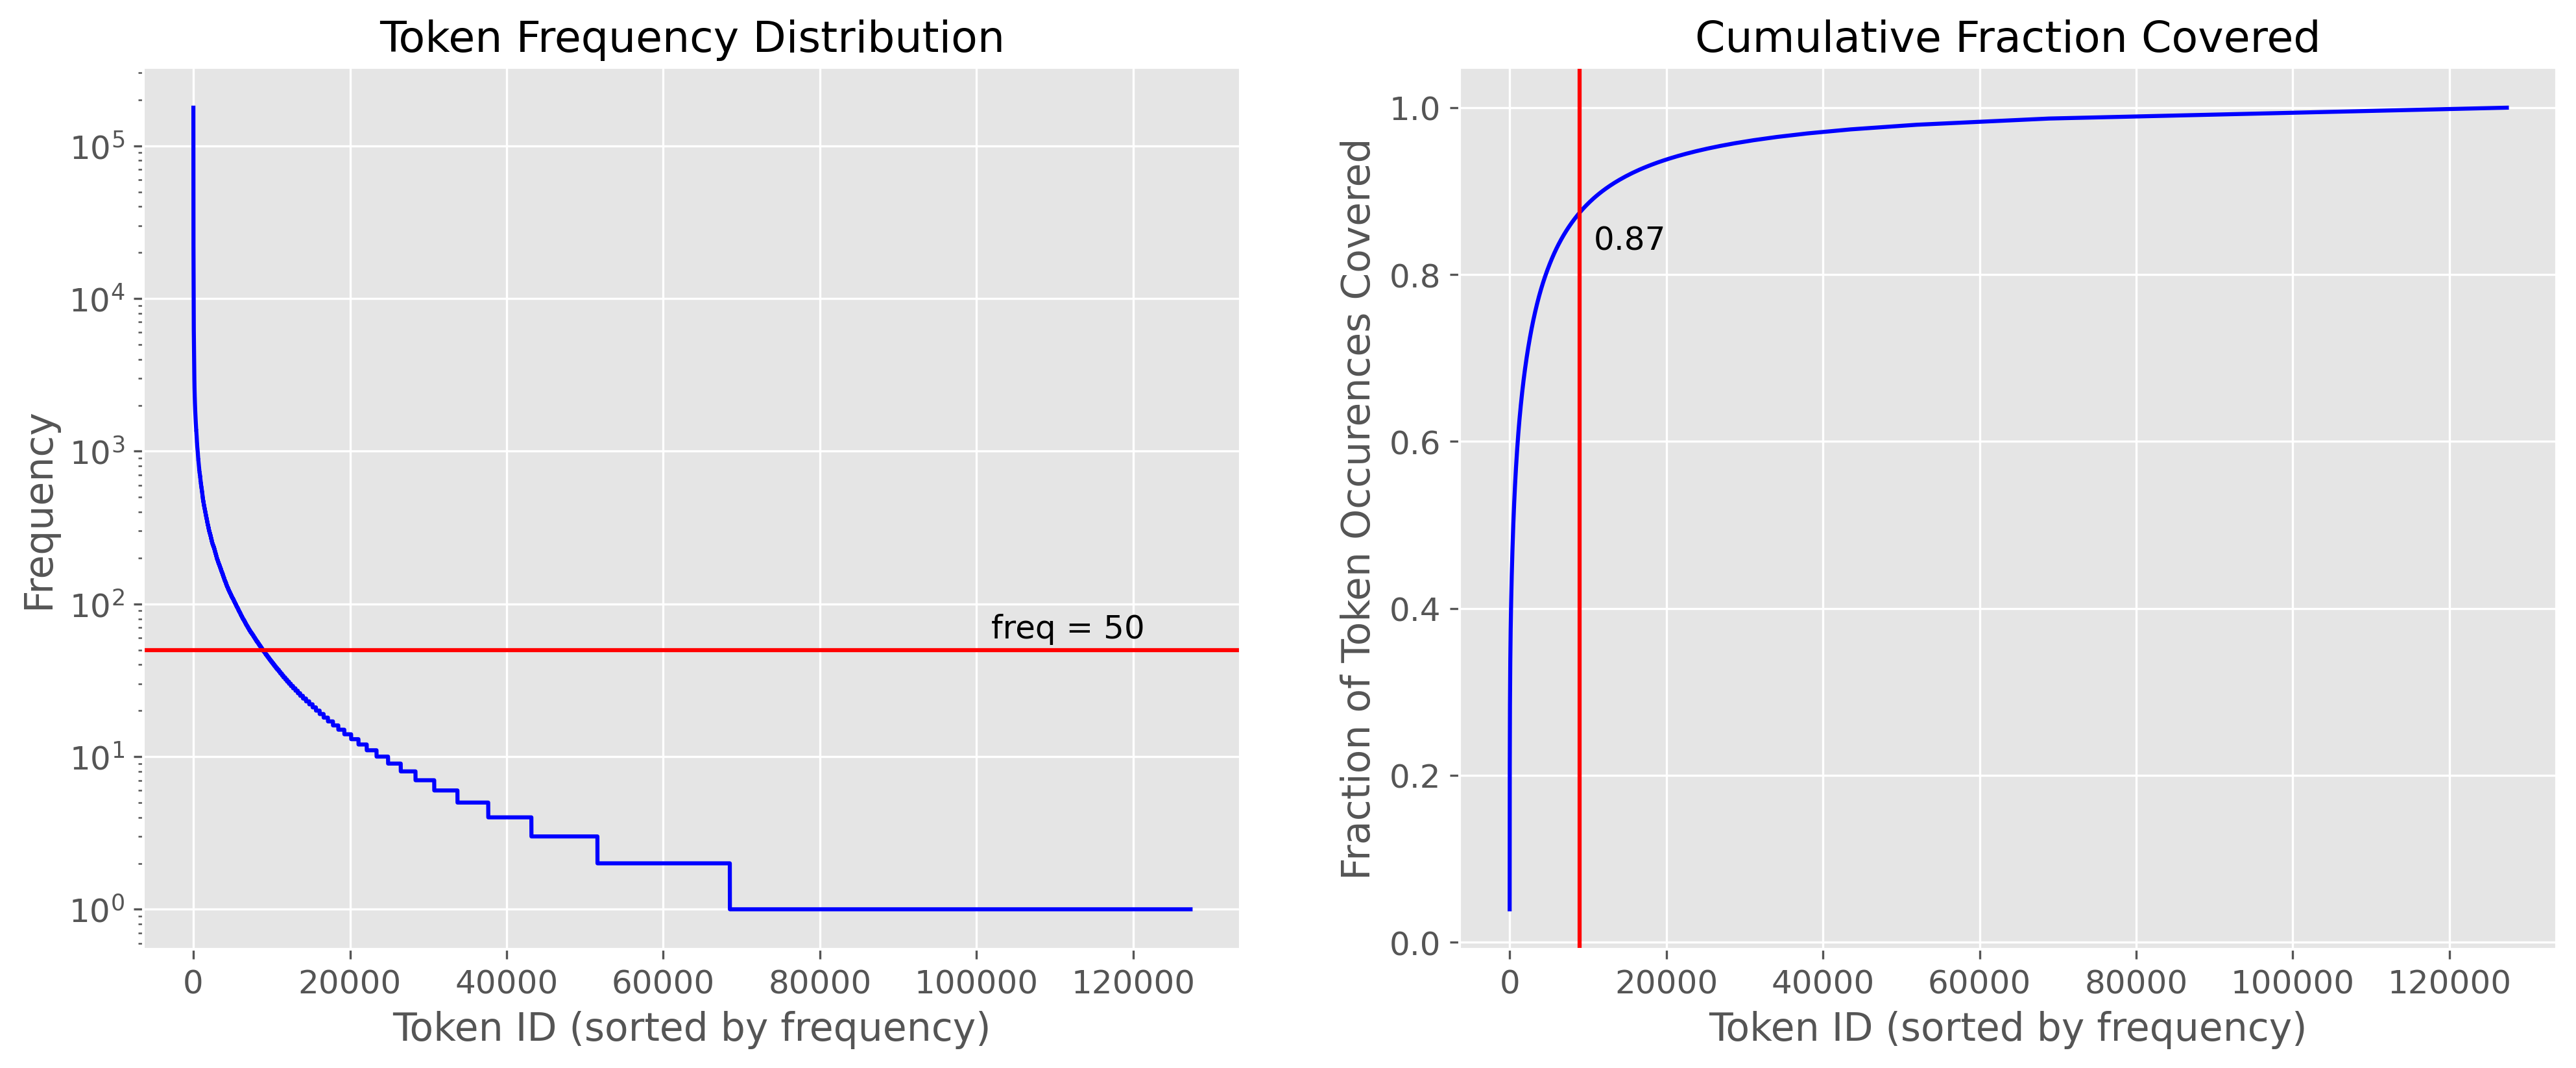

In [187]:
vocab.make_vocab_charts()

In [ ]:
len(vocab)

# 2. Frequency-Based Word Vectors - PPMI

In [55]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.utils.extmath import randomized_svd
import logging
import itertools
from sklearn.manifold import TSNE

import random
random.seed(42)
np.random.seed(42)

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

class UnimplementedFunctionError(Exception):
    pass


###########################
## TASK 2.2              ##
###########################

def compute_cooccurrence_matrix(corpus, vocab):
    """
        
        compute_cooccurrence_matrix takes in list of strings corresponding to a text corpus and a vocabulary of size N and returns 
        an N x N count matrix as described in the handout. It is up to the student to define the context of a word

        :params:
        - corpus: a list strings corresponding to a text corpus
        - vocab: a Vocabulary object derived from the corpus with N words

        :returns: 
        - C: a N x N matrix where the i,j'th entry is the co-occurrence frequency from the corpus between token i and j in the vocabulary

        """ 
    n = len(vocab)
    coor_matrix = np.zeros([n,n])
    context_len = 2
    n_context = 0
    for text in corpus:
        text = "UNK UNK " + text + " UNK UNK"    # Avoid out of bound contexts
        indices = vocab.text2idx(text)
        n_context += (len(indices) - context_len*4)
        
        for i in range(3, len(indices) - 2):
            for j in range(i - 2, i):
                word = indices[i]
                context = indices[j]
                coor_matrix[word][context] += 1
                
            for j in range(i + 1, i + 3):
                word = indices[i]
                context = indices[j]
                coor_matrix[word][context] += 1
    
    return coor_matrix, n_context


In [61]:
coor_matrix, n_context = compute_cooccurrence_matrix(dataset['train']['text'], vocab)

In [67]:
for i in range(50):
    print(coor_matrix[i][i])

429591.0
1686.0
3324.0
372.0
1928.0
1334.0
840.0
518.0
156.0
82.0
68.0
49.0
28.0
2924.0
46.0
32.0
32.0
20.0
18.0
66.0
8.0
8452.0
14.0
134.0
15396.0
2.0
54.0
6.0
16.0
2.0
6.0
8.0
12.0
6.0
34.0
5.0
4.0
2.0
2.0
140.0
124.0
0.0
4.0
4.0
2.0
2.0
2.0
6.0
21.0
0.0


In [ ]:
def compute_ppmi_matrix(corpus, vocab):
    """
        
        compute_ppmi_matrix takes in list of strings corresponding to a text corpus and a vocabulary of size N and returns 
        an N x N positive pointwise mutual information matrix as described in the handout. Use the compute_cooccurrence_matrix function. 

        :params:
        - corpus: a list strings corresponding to a text corpus
        - vocab: a Vocabulary object derived from the corpus with N words

        :returns: 
        - PPMI: a N x N matrix where the i,j'th entry is the estimated PPMI from the corpus between token i and j in the vocabulary

        """ 
    coor_matrix, n_context = compute_cooccurrence_matrix(corpus, vocab)
    n = len(vocab)
    word_count = np.zeros((1,n))
    
    for text in corpus:
        indices = vocab.text2idx(text)
        
        for idx in indices:
            word_count[0][idx] += 1
        
    prob = np.add(np.transpose(word_count).dot(word_count), 0.000001) 
    
    ppmi = np.maximum(np.log(np.add(np.divide(np.multiply(coor_matrix, n_context), prob), 0.000001)), 0)
    
    return ppmi

ppmi = compute_ppmi_matrix(dataset['train']['text'], vocab)
ppmi

In [ ]:
def dim_reduce(PPMI, k=16):
    U, Sigma, VT = randomized_svd(PPMI, n_components=k, n_iter=10, random_state=42)
    SqrtSigma = np.sqrt(Sigma)[np.newaxis,:]

    U = U*SqrtSigma
    V = VT.T*SqrtSigma

    word_vectors = np.concatenate( (U, V), axis=1) 
    word_vectors = word_vectors / np.linalg.norm(word_vectors, axis=1)[:,np.newaxis]

    return word_vectors


def plot_word_vectors_tsne(word_vectors, vocab):
    coords = TSNE(metric="cosine", perplexity=50, random_state=42).fit_transform(word_vectors)

    plt.cla()
    top_word_idx = vocab.text2idx(" ".join(vocab.most_common(1000)))
    plt.plot(coords[top_word_idx,0], coords[top_word_idx,1], 'o', markerfacecolor='none', markeredgecolor='k', alpha=0.5, markersize=3)

    for i in tqdm(top_word_idx):
        plt.annotate(vocab.idx2text([i])[0],
            xy=(coords[i,0],coords[i,1]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize=5)
    plt.show()

word_vectors = dim_reduce(ppmi)
plot_word_vectors_tsne(word_vectors, vocab)

# 3. Learning-Based Word Vectors - GloVe

In [2]:
import os
from datasets import load_dataset
from Vocabulary import Vocabulary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import logging
import itertools
from sklearn.manifold import TSNE
from build_freq_vectors import compute_cooccurrence_matrix,plot_word_vectors_tsne

def main_glove():

    logging.info("Loading dataset")
    dataset = load_dataset("ag_news")
    dataset_text =  [r['text'] for r in dataset['train']]
    dataset_labels = [r['label'] for r in dataset['train']]


    logging.info("Building vocabulary")
    vocab = Vocabulary(dataset_text)
    plt.close()
    plt.pause(0.01)


    logging.info("Computing count matrix")
    
    if os.path.exists("coor_matrix.npy"):
        C = np.load("coor_matrix.npy")
    else:
        C = compute_cooccurrence_matrix( [doc['text'] for doc in dataset['train']], vocab)

    ########################################################################
    # Hyperparmeters and Optimization Variables
    ########################################################################

    d = 32              # dimensionality of the vectors
    B = 2048            # batch size (in number of word pairs)
    maxEpoch = 20        # maximum number of epochs
    learningRate = 0.1  # learning rate / step size for SGD
    clip = 50           # gradient clip value 
    m = 0.9             # moment parameter

    # Initialize word vectors randomly
    wordvecs = np.random.rand(vocab.size, d)
    contextvecs = np.random.rand(vocab.size, d)
    
    # Initalize biases to approximate occurence frequency
    wordbiases = np.log(np.mean(C, axis=1))[:, np.newaxis]
    contextbiases = np.log(np.mean(C, axis=0))[:,np.newaxis]
    
    # Create empty variables to store gradients for momentum
    wordvecs_momentum = np.zeros( (vocab.size, d) ) 
    contextvecs_momentum = np.zeros( (vocab.size, d) ) 
    wordbiases_momentum = np.zeros( (vocab.size, 1) ) 
    contextbiases_momentum = np.zeros( (vocab.size, 1) ) 

    # Get all non-zero word-pair co-occurences
    idx = np.vstack(np.nonzero(C)).T
    shuf = list(range(idx.shape[0]))
    logging.info("{} non-zero entries in the count matrix".format(idx.shape[0]))
    

    logging.info("Starting GloVe optimization")
    for epoch in range(maxEpoch):
        
        # Shuffle order that word-pair will be seen
        np.random.shuffle(shuf)

        # Start an epoch
        logging.info("Epoch {} / {}: learning rate = {}".format(epoch+1,maxEpoch, learningRate))
        loss = 0

        # for each batch
        for b in range(idx.shape[0]//B+1):
            
            # Get indexes for word-pairs in the batch
            shuf_idx = shuf[b*B:min((b+1)*B, idx.shape[0])]
            bSize = min((b+1)*B, idx.shape[0])-b*B
            i = idx[shuf_idx, 0]
            j = idx[shuf_idx, 1]

            # Get word and context vectors for pairs in the batch
            w_batch = wordvecs[i, :]
            c_batch = contextvecs[j, :]

            # Compute f(C_i,j) for i,j pairs in batch (Bx1 dimensional vector)
            fval = (np.minimum(1, C[i, j]/100)**0.75)[:,np.newaxis]
            assert fval.shape == (bSize,1), "Incorrect dimension for the vector \
                of weights, should be (batch_size x 1)"

            # Compute error term as (w_i^T c_j + b_i + b_i - log(C_ij)) for each i,j pair in the batch. (Bx1 dimensional vector)
            error = (np.sum(np.multiply(w_batch, c_batch), axis=1)[:,np.newaxis] 
                     + wordbiases[i] + contextbiases[j] 
                     - np.log(C[i,j])[:,np.newaxis])
            assert error.shape == (bSize,1), "Incorrect dimension for the vector \
                of errors, should be (batch_size x 1)"

            # Combine the overall objective loss
            loss += np.sum(fval*np.square(error))


            ########################################################################
            # Task 3.2
            ########################################################################
            # write expressions using numpy to implement the gradients you derive in 3.1. 
            wordvecs_grad = np.zeros( (bSize,d) )
            wordbiases_grad = np.zeros( (bSize,1) )
            contextvecs_grad = np.zeros( (bSize,d) )
            contextbiases_grad = np.zeros( (bSize,1) )
            
            contextbiases_grad = wordbiases_grad = np.multiply(np.multiply(fval, 2), error)
            wordvecs_grad = np.multiply(wordbiases_grad, c_batch)
            contextvecs_grad = np.multiply(contextbiases_grad, w_batch)
            

            ########################################################################
    
            assert wordvecs_grad.shape == (bSize,d), "Incorrect dimension, should be (batch_size x d)"
            assert contextvecs_grad.shape == (bSize,d), "Incorrect dimension, should be (batch_size x d)"
            assert wordbiases_grad.shape == (bSize,1), "Incorrect dimension, should be (batch_size x 1)"
            assert contextbiases_grad.shape == (bSize,1), "Incorrect dimension, should be (batch_size x 1)"


            # Update momentum
            wordvecs_momentum *= m
            wordbiases_momentum *= m
            contextvecs_momentum *= m
            contextbiases_momentum *= m

            wordvecs_momentum[i,:] +=  (1-m)*wordvecs_grad
            wordbiases_momentum[i] +=  (1-m)*wordbiases_grad

            contextvecs_momentum[j,:] += (1-m)*contextvecs_grad
            contextbiases_momentum[j] += (1-m)*contextbiases_grad


            # Apply the gradient step (with momentum and gradient clipping)
            wordvecs[i,:] -= np.maximum(np.minimum(learningRate*wordvecs_momentum[i,:], clip),-clip)
            wordbiases[i] -= np.maximum(np.minimum(learningRate*wordbiases_momentum[i], clip),-clip)
            
            contextvecs[j,:] -= np.maximum(np.minimum(learningRate*contextvecs_momentum[j,:], clip),-clip)
            contextbiases[j] -= np.maximum(np.minimum(learningRate*contextbiases_momentum[j], clip),-clip)


            if b % 100 == 0 and b > 0:
                logging.info("Iter {} / {}: avg. loss over last 100 batches = {}".format(b, idx.shape[0]//B, loss/(B*100)))
                loss = 0

In [9]:
main_glove(coor_matrix)

/Users/johnnybui/opt/miniconda3/envs/torch-mps/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


AxisError: axis 1 is out of bounds for array of dimension 1

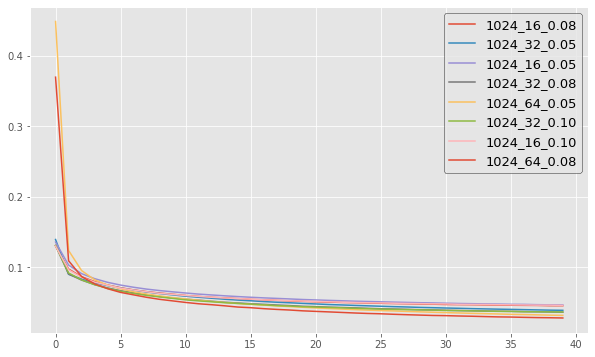

In [172]:
import os
import csv
import re
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(10,6))

file = open("./1024_16_0.05_loss.csv", "r")
reader = csv.reader(file)

for dir in os.listdir("."):
    if "loss.csv" in dir:
        with open(dir, 'r') as file:
            # batch size, dimensionality, learning rate
            params = re.split(r'_', dir)
            
            reader = csv.reader(file)
            ave_loss_per_epoch = []
            for row in reader:
                loss = list(map(lambda x: float(x), row))
                n_iter_per_epoch = int(len(loss) / 40) # n_epoch = 40
                
                # sum / n -> average loss per epoch
                for i in range(0, len(loss), n_iter_per_epoch):
                    ave_loss_per_epoch.append(sum(loss[i:i + n_iter_per_epoch]) 
                                              / n_iter_per_epoch)
                
                if "1024" in dir:
                    plt.plot(range(len(ave_loss_per_epoch)), ave_loss_per_epoch, 
                            label=("%s_%s_%s" % (params[0], params[1], params[2])))
                    plt.legend()
                else:
                    pass
                

# 4. Exploring Learned Biases in word2vec Vectors

In [1]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim import downloader

glove_model = downloader.load('word2vec-google-news-300')

In [5]:
def analogy (a, b, c):
    print (a+" : "+b+" :: "+c+" : ?")
    print ([(w, round (c ,3) ) for w,c in glove_model.most_similar ( positive =[c,b], negative =[a]) ])

### 3 Analogies that make sense

In [85]:
analogy('Messi','Argentina','Neymar')

Messi : Argentina :: Neymar : ?
[('Brazil', 0.622), ('Uruguay', 0.581), ('Chile', 0.561), ('Ecuador', 0.56), ('Argentine', 0.555), ('Argentinean', 0.535), ('Paraguay', 0.525), ('Peru', 0.521), ('Argentinian', 0.505), ('striker_Neymar', 0.503)]


In [165]:
analogy('football','uk','soccer')

football : uk :: soccer : ?
[('canada', 0.585), ('usa', 0.585), ('australia', 0.525), ('india', 0.511), ('germany', 0.502), ('malaysia', 0.501), ('amsterdam', 0.5), ('denmark', 0.496), ('thailand', 0.488), ('bbc', 0.483)]


In [33]:
analogy('China','Beijing','France')

China : Beijing :: France : ?
[('Paris', 0.721), ('French', 0.624), ('Colombes', 0.609), ('Marseille', 0.597), ('Melun', 0.589), ('Aix_en_Provence', 0.578), ('Issy_les_Moulineaux', 0.578), ('Montpellier', 0.574), ('Toulouse', 0.571), ('Nantes', 0.566)]


### 3 analogies that don't make sense

In [73]:
analogy('China','Beijing','United_States')

China : Beijing :: United_States : ?
[('Unites_States', 0.58), ('U.S.', 0.569), ('United_Sates', 0.539), ('Untied_States', 0.532), ('theUnited_States', 0.488), ('Washington_DC', 0.477), ('Washington', 0.465), ('UnitedStates', 0.453), ('Great_Britain', 0.444), ('Athens_Greece', 0.439)]


In [105]:
analogy('Adele','England','Beyonce')

Adele : England :: Beyonce : ?
[('stock_symbol_BNK', 0.467), ('Freddie_Flintoff', 0.458), ('ticker_symbol_BNK', 0.455), ('DAILY_STAR_Fabio_Capello', 0.446), ('Wayne_Rooney', 0.446), ('David_Beckham', 0.444), ('NatWest_Challenge', 0.437), ('Beyoncé', 0.434), ('Frank_Lampard', 0.429), ('midfielder_Frank_Lampard', 0.427)]


In [166]:
analogy('FIS','Russia','CIA')

FIS : CIA :: Russia : ?
[('Kremlin', 0.506), ('former_Soviet_republics', 0.494), ('Moscow', 0.482), ('Soviet', 0.474), ('former_Soviet_Republics', 0.473), ('CIA_operatives', 0.47), ('Russian', 0.467), ('Soviet_Union', 0.466), ('Ukraine', 0.465), ('spy', 0.46)]


### Bias

In [146]:
analogy('male','height','female')
# analogy('Asian','professor','African')

male : driver :: female : ?
[('drivers', 0.652), ('Driver', 0.535), ('Akar_Besir_Turkish', 0.534), ('dirver', 0.525), ('motorist', 0.506), ('Correspondent_Asaad_Kadhim', 0.502), ('wheel', 0.491), ('Jerome_Niemeyer', 0.489), ('Bia_Figueiredo', 0.486), ('L_plater', 0.486)]


In [168]:
word = 'smuggler'
analogy('Miguel', word, 'Gabe')
analogy('Gabe', word,'Miguel')

Miguel : smuggler :: Gabe : ?
[('smugglers', 0.486), ('smuggling', 0.449), ('Smugglers', 0.406), ('smuggled', 0.397), ('Rabiyah', 0.387), ('trafficker', 0.386), ('smuggle', 0.385), ('drug_smuggler', 0.378), ('Zach', 0.375), ('informant', 0.373)]
Gabe : smuggler :: Miguel : ?
[('smugglers', 0.596), ('migrant_smuggler', 0.542), ('trafficker', 0.54), ('smuggling', 0.529), ('traffickers', 0.507), ('drug_trafficker', 0.505), ('Colombian_traffickers', 0.504), ('Juárez_Cartel', 0.501), ('immigrant_smuggler', 0.494), ('border_crosser', 0.483)]


In [151]:
word = 'translator'
analogy('Caucasian', word, 'Asian')
analogy('Asian', word,'Caucasian')
# analogy('Asian','professor','African')

Caucasian : ignorant :: Asian : ?
[('uninformed', 0.479), ('woefully_ignorant', 0.447), ('clueless', 0.439), ('uneducated', 0.418), ('Asia', 0.416), ('ignorance', 0.4), ('Southeast_Asian', 0.398), ('misinformed', 0.396), ('gullible', 0.39), ('SIngapore', 0.386)]
Asian : ignorant :: Caucasian : ?
[('uninformed', 0.597), ('uneducated', 0.578), ('narrowminded', 0.561), ('unintelligent', 0.553), ('misinformed', 0.548), ('ignorant_uneducated', 0.546), ('miseducated', 0.543), ('ignorant_bigoted', 0.541), ('willfully_ignorant', 0.54), ('racists_bigots', 0.523)]


In [143]:
analogy('African','professor','Asian')
analogy('Asian','professor','African')

African : professor :: Asian : ?
[('associate_professor', 0.64), ('assistant_professor', 0.629), ('professor_emeritus', 0.614), ('Associate_Professor', 0.568), ('emeritus_professor', 0.557), ('economics_professor', 0.547), ('sociology_professor', 0.542), ('Assistant_Professor', 0.542), ('psychology_professor', 0.531), ('lecturer', 0.529)]
Asian : professor :: African : ?
[('professor_emeritus', 0.617), ('associate_professor', 0.601), ('lecturer', 0.595), ('emeritus_professor', 0.59), ('assistant_professor', 0.567), ('adjunct_professor', 0.547), ('Professor', 0.536), ('sociologist', 0.533), ('profesor', 0.513), ('Professor_Emeritus', 0.509)]


In [127]:
analogy('boy','soccer','girl')
analogy('girl','soccer','boy')

boy : soccer :: girl : ?
[('volleyball', 0.694), ('softball', 0.668), ('Soccer', 0.649), ('basketball', 0.632), ('lacrosse', 0.618), ('water_polo', 0.596), ('football', 0.596), ('Volleyball', 0.589), ('tennis', 0.585), ('hockey', 0.564)]
girl : soccer :: boy : ?
[('Soccer', 0.692), ('football', 0.692), ('basketball', 0.566), ('fooball', 0.545), ('sports', 0.542), ('baseball', 0.542), ('futbol', 0.542), ('hockey', 0.54), ('SOCCER', 0.532), ('Futsal', 0.518)]


In [162]:
glove_model.most_similar(positive=["flowers"])

[('roses', 0.7850948572158813),
 ('flower', 0.7488503456115723),
 ('bouquets', 0.7340125441551208),
 ('carnations', 0.7086026072502136),
 ('edible_Kolla', 0.6979554891586304),
 ('flower_bouquets', 0.6941022872924805),
 ('tulips', 0.6911165118217468),
 ('flower_arrangements', 0.688910961151123),
 ('floral_arrangements', 0.6846922636032104),
 ('lilies', 0.6831052303314209)]